## Import Libraries

In [1]:
import pysift
import cv2 
import pickle
import matplotlib.pyplot as plt

### Resize Images function

In [26]:
# Resize images to a similar dimension
# This helps improve accuracy and decreases unnecessarily high number of keypoints

def imageResize(image):
    maxD = 1000
    height,width,channels = image.shape
    aspectRatio = width/height
    if aspectRatio < 1:
        newSize = (int(maxD*aspectRatio),maxD)
    else:
        newSize = (maxD,int(maxD/aspectRatio))
    image = cv2.resize(image,newSize)
    return image

## Generate Keypoint and Descriptors

### Prepare list of images

In [27]:
# Define a list of images the way you like

imageList = ["taj1.jpeg","taj2.jpeg","eiffel1.jpeg","eiffel2.jpeg","liberty1.jpeg","liberty2.jpeg","robert1.jpeg","tom1.jpeg","ironman1.jpeg","ironman2.jpeg","darkknight1.jpeg","darkknight2.jpeg"]

In [28]:
images = []
for image in imageList:
    images.append(imageResize(cv2.imread(image)))

In [29]:
# Gray-scasle images improve speed

imageBW = []
for image in images:
    imageBW.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

### The following is the main function to generate the keypoints and descriptors<br>
When using SIFT, this takes a lot of time to compute.<br>
Thus, it is suggested, you store the values once computed<br>
(Code for storing is written below)

In [31]:
keypoints = []
descriptors = []
i = 0
for image in imageBW:
    print("Starting for image: " + imageList[i])
    keypointTemp, descriptorTemp = pysift.computeKeypointsAndDescriptors(image)
    keypoints.append(keypointTemp)
    descriptors.append(descriptorTemp)
    print("  Ending for image: " + imageList[i])
    i += 1

Starting for image: taj1.jpeg
  Ending for image: taj1.jpeg
Starting for image: taj2.jpeg
  Ending for image: taj2.jpeg
Starting for image: eiffel1.jpeg
  Ending for image: eiffel1.jpeg
Starting for image: eiffel2.jpeg
  Ending for image: eiffel2.jpeg
Starting for image: liberty1.jpeg
  Ending for image: liberty1.jpeg
Starting for image: liberty2.jpeg
  Ending for image: liberty2.jpeg
Starting for image: robert1.jpeg
  Ending for image: robert1.jpeg
Starting for image: tom1.jpeg
  Ending for image: tom1.jpeg
Starting for image: ironman1.jpeg
  Ending for image: ironman1.jpeg
Starting for image: ironman2.jpeg
  Ending for image: ironman2.jpeg
Starting for image: darkknight1.jpeg
  Ending for image: darkknight1.jpeg
Starting for image: darkknight2.jpeg
  Ending for image: darkknight2.jpeg


### Store Keypoints and Descriptors for future use

In [32]:
i = 0
for keypoint in keypoints:
    deserializedKeypoints = []
    filepath = "data/keypoints/" + str(imageList[i].split('.')[0]) + ".txt"
    for point in keypoint:
        temp = (point.pt, point.size, point.angle, point.response, point.octave, point.class_id)
        deserializedKeypoints.append(temp)
    with open(filepath, 'wb') as fp:
        pickle.dump(deserializedKeypoints, fp)    
    i += 1

In [33]:
i = 0
for descriptor in descriptors:
    filepath = "data/descriptors/" + str(imageList[i].split('.')[0]) + ".txt"
    with open(filepath, 'wb') as fp:
        pickle.dump(descriptor, fp)
    i += 1

## Prepare for fetching results

### Fetch Keypoints and Descriptors from stored files

In [34]:
def fetchKeypointFromFile(i):
    filepath = "data/keypoints/" + str(imageList[i].split('.')[0]) + ".txt"
    keypoint = []
    file = open(filepath,'rb')
    deserializedKeypoints = pickle.load(file)
    file.close()
    for point in deserializedKeypoints:
        temp = cv2.KeyPoint(x=point[0][0],y=point[0][1],_size=point[1], _angle=point[2], _response=point[3], _octave=point[4], _class_id=point[5])
        keypoint.append(temp)
    return keypoint

In [35]:
def fetchDescriptorFromFile(i):
    filepath = "data/descriptors/" + str(imageList[i].split('.')[0]) + ".txt"
    file = open(filepath,'rb')
    descriptor = pickle.load(file)
    file.close()
    return descriptor

### Calculate Results for any pair

In [36]:
def calculateResultsFor(i,j):
    keypoint1 = fetchKeypointFromFile(i)
    descriptor1 = fetchDescriptorFromFile(i)
    keypoint2 = fetchKeypointFromFile(j)
    descriptor2 = fetchDescriptorFromFile(j)
    matches = calculateMatches( descriptor1, descriptor2)
    score = calculateScore(len(matches),len(keypoint1),len(keypoint2))
    plot = getPlotFor(i,j,keypoint1,keypoint2,matches)
    print(len(matches),len(keypoint1),len(keypoint2),len(descriptor1),len(descriptor2))
    print(score)
    plt.imshow(plot),plt.show()

In [39]:
def getPlotFor(i,j,keypoint1,keypoint2,matches):
    image1 = imageResize(cv2.imread(imageList[i]))
    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    image2 = imageResize(cv2.imread(imageList[j]))
    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    return getPlot(image1,image2,keypoint1,keypoint2,matches)

### Basic Scoring metric
A score greater than 10 means very good

In [38]:
def calculateScore(matches,keypoint1,keypoint2):
    return 100 * (matches/min(keypoint1,keypoint2))

### Use this part of code for brute force matching

In [37]:
# bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
# def calculateMatches(descriptor1,descriptor2):
#     matches = bf.match(descriptor1,descriptor2)
#     matches = sorted(matches, key = lambda x:x.distance)
#     return matches

In [40]:
# def getPlot(image1,image2,keypoint1,keypoint2,matches):
#     matchPlot = cv2.drawMatches(image1, keypoint1, image2, keypoint2, matches[:50], image2, flags=2)
#     return matchPlot

### Use this part of code for knn matching

In [48]:
bf = cv2.BFMatcher()
def calculateMatches(des1,des2):
    matches = bf.knnMatch(des1,des2,k=2)
    topResults = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            topResults.append([m])
    return topResults

In [ ]:
def getPlot(image1,image2,keypoint1,keypoint2,matches):
    matchPlot = cv2.drawMatchesKnn(image1,keypoint1,image2,keypoint2,matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    return matchPlot

## Fetch Results

### Sample Results

24 2822 3388 2822 3388
0.8504606661941885


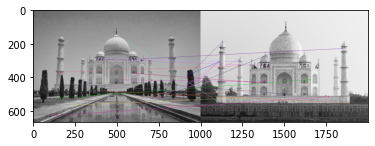

22 1781 2345 1781 2345
1.235261089275688


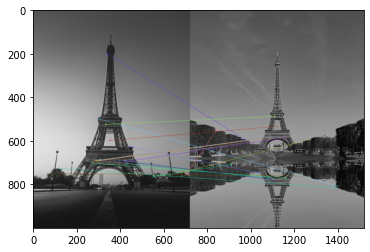

20 2037 1300 2037 1300
1.5384615384615385


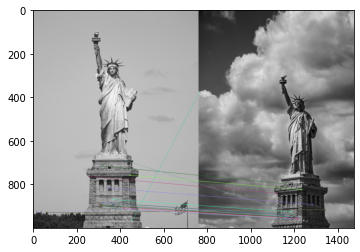

15 1618 3703 1618 3703
0.9270704573547589


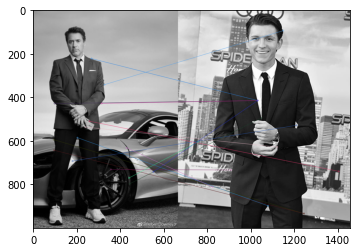

408 1267 643 1267 643
63.45256609642301


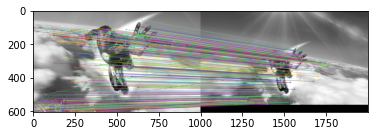

612 2137 1690 2137 1690
36.213017751479285


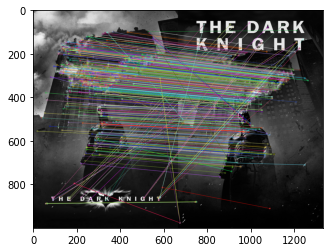

44 2822 643 2822 643
6.842923794712286


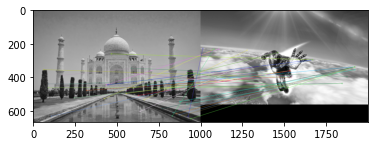

14 1781 643 1781 643
2.177293934681182


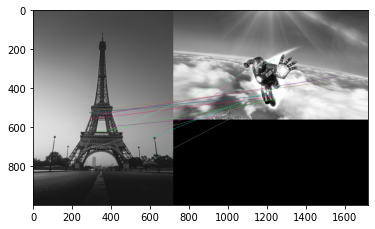

8 1300 643 1300 643
1.244167962674961


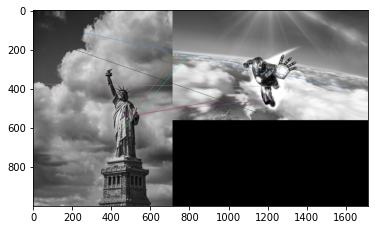

6 1781 1690 1781 1690
0.35502958579881655


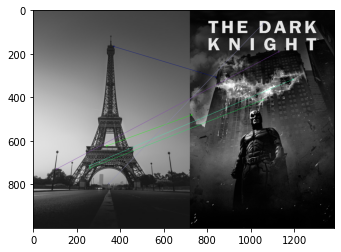

In [49]:
calculateResultsFor(0,1)
calculateResultsFor(2,3)
calculateResultsFor(4,5)
calculateResultsFor(6,7)
calculateResultsFor(8,9)
calculateResultsFor(10,11)
calculateResultsFor(0,9)
calculateResultsFor(2,9)
calculateResultsFor(5,9)
calculateResultsFor(2,11)